In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tsfresh import select_features
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve
from sklearn import metrics
import pickle
import joblib
import re
from collections import Counter
import sys, os
import random

### Configuration:
1) WIN_SIZE: window crop on actin intensity measurements
2) diff_window: window crop on actin intensity measurements
3) con_window: frames ro train the model on control group

In [2]:
WIN_SIZE=16 
diff_window=[130, 160]
con_window=[[0, 30], [40, 70], [90, 120], [130, 160], [180, 210], [220, 250]] 

# Load and preprocess the data #

In [3]:
def clean_redundant_columns(df):
    """
    Removes redundant columns from the DataFrame based on a specific pattern.

    :param df: (pd.DataFrame) DataFrame to clean.
    :return: (pd.DataFrame) DataFrame with redundant columns removed.
    """
    remove_cols = []
    cols_to_remove = ["target"]
    for col_to_remove in cols_to_remove:
        for col_name in df.columns:
            if col_name.startswith(col_to_remove):
                remove_cols.append(col_name)
    df = df.drop(columns=remove_cols)
    return df

In [4]:
def concat_dfs(diff_df, con_df, diff_t_window=None, con_t_windows=None):
    """
    Concatenates the ERK and control dataframes into a single dataframe for further processing.
    The function cuts the required time windows from the dataframes and assigns target labels.

    :param diff_df: (pd.DataFrame) Dataframe containing the ERK data.
    :param con_df: (pd.DataFrame) Dataframe containing the control data.
    :param diff_t_window: (Optional[Tuple[int, int]]) Time window for the ERK data (start frame, end frame)
                            (default: None).
    :param con_t_windows: (Optional[List[Tuple[int, int]]]) Time windows for the control data (list of start and end
                            frames) (default: None).
    :return: (pd.DataFrame) Concatenated dataframe containing the ERK and control data.
    """
        
    def set_indexes(df, target, max_val):
        df["Spot track ID"] = df["Spot track ID"] + max_val
        max_val = df["Spot track ID"].max() + 1
        df['target'] = np.array([target for i in range(len(df))])
        return df, max_val

    max_val = 0
    diff_start, diff_end = diff_t_window
    window_size = diff_end - diff_start

    # Erk video
    # Cut the needed time window
    new_diff_df = pd.DataFrame()
    diff_df = diff_df[diff_df["Spot frame"] == diff_end]
    print("size of diff_df: ", diff_df.shape)

    for label, label_df in diff_df.groupby('Spot track ID'):
        # new_diff_df = new_diff_df.append(label_df)
        new_diff_df = pd.concat([new_diff_df, label_df], ignore_index=True)

    # control video
    # Cut the needed time window
    control_df = pd.DataFrame()
    new_label = max(con_df['Spot track ID'].unique()) + 1
    for start, end in con_t_windows:
        tmp_df = con_df[con_df["Spot frame"] == end]
        for label, label_df in tmp_df.groupby('Spot track ID'):
            new_label += 1
            label_df["Spot track ID"] = new_label
            # control_df = control_df.append(label_df)
            control_df = pd.concat([control_df, label_df], ignore_index=True)
    con_df = control_df.copy()
    print("size of con_df: ", con_df.shape)

    new_diff_df, max_val = set_indexes(new_diff_df, target=True, max_val=max_val)
    con_df, _ = set_indexes(con_df, target=False, max_val=max_val)
    total_df = pd.concat([new_diff_df, con_df], ignore_index=True)
    return total_df


In [5]:
def downcast_df(data_copy, fillna=True):
    """
    Downcasts the data types of a DataFrame to reduce memory usage.
    :param data_copy: (pd.DataFrame) The DataFrame to be downcasted.
    :param fillna: (bool, optional) Whether to fill NaN values with zero. Default is True.
    :return: (pd.DataFrame) The downcasted DataFrame.
    """
    data_copy = data_copy.copy()
    if fillna:
        data_copy = data_copy.fillna(0)
    data_copy = data_copy.dropna(axis=1)
    cols = list(data_copy.drop(columns="Spot track ID").columns) if "spot track ID" in data_copy.columns else list(
        data_copy.columns)
    for col in cols:
        try:
            if data_copy[col].sum().is_integer():
                data_copy[col] = pd.to_numeric(data_copy[col], downcast='integer')
            else:
                data_copy[col] = pd.to_numeric(data_copy[col], downcast='float')

            if np.isinf(data_copy[col]).sum() > 0:
                data_copy[col] = data_copy[col]
        except:
            continue
    return data_copy


In [6]:
def load_tsfresh_pkl(transfromed_pkl_path):
    """
    Loads the TSFRESH-transformed data from a pickle file.

    :param transformed_pkl_path: (str) Path template for the transformed pickle file.
    :return: (pd.DataFrame) Loaded TSFRESH-transformed data.
    """
    print(f"read data from {transfromed_pkl_path}")
    df = pickle.load(open(transfromed_pkl_path, 'rb'))
    df = downcast_df(df, fillna=False)
    df = clean_redundant_columns(df)
    return df

### Loads and cleans the transformed data for training and testing sets: 
####
1) con_df_train: the control (DMSO) training set.
2) con_df_test: the control (DMSO) testing set.
3) diff_df_train: the differentiation (ERKi) training set.
4) diff_df_test: the differentiation (ERKi) testing set. 


##### The data is data frame after preprocesses a data chunk by calculating actin intensity features, normalizing data, and transforming it to tsfresh features vector.


In [ ]:

diff_df_train = load_tsfresh_pkl('data/diff_df_train.pickle')
print(f"diff train len: {diff_df_train.shape}", flush=True)

con_df_train = load_tsfresh_pkl('data/con_df_train.pickle')
print(f"con_df_train len: {con_df_train.shape}", flush=True)

diff_df_test = load_tsfresh_pkl('data/diff_df_test.pickle')

con_df_test = load_tsfresh_pkl('data/con_df_test.pickle')

# Train and build the model #

In [8]:
def evaluate(clf, X_test, y_test):
    """
    Evaluates the performance of a classifier on the test data. It predicts the labels using the classifier,
    generates a classification report, calculates the AUC score based on the predicted labels and true labels,
    and returns the classification report and AUC score.

    :param clf: (classifier) The trained classifier.
    :param X_test: (pd.DataFrame) Test features.
    :param y_test: (pd.Series) True labels for the test data.
    :return: (Tuple[str, float]) Classification report and AUC score.
    """
        
    pred = clf.predict(X_test)
    report = classification_report(y_test, pred)

    fpr, tpr, thresholds = roc_curve(y_test, pred, pos_label=1)
    auc_score = metrics.auc(fpr, tpr)
    print(auc_score)
    return auc_score, report

In [9]:
def evaluate_clf(dir_path, clf, X_test, y_test, y_train, diff_window, con_window):
    """
    Evaluates a classifier model by generating a classification report and calculating the AUC score.
    It also plots the ROC curve, saves the classification report, AUC score, and additional information in a text file.

    :param dir_path: (str) Directory path to save the evaluation results.
    :param clf: (Any) Classifier model to evaluate.
    :param X_test: (pd.DataFrame) Test features.
    :param y_test: (pd.Series) Test target variable.
    :param y_train: (pd.Series) Train target variable.
    :param diff_window: (int) ERK differentiation window size.
    :param con_window: (int) control (DMSO) window size.
    :return: (float) AUC score.
    """
    auc_score, report = evaluate(clf, X_test, y_test)
    txt_file = open(dir_path + '/info.txt', 'a')
    txt_file.write(
                    f"classification report: {report}"
                   f"\n auc score: {auc_score}"
                   f"\n train samples:{Counter(y_train)}"
                   f"\n {diff_window} ERK, {con_window} con frames"
                   f"\n n features= {X_test.shape}")

    txt_file.close()

    return auc_score

In [10]:
def save_data(dir_path, clf=None, X_train=None, X_test=None, y_train=None, y_test=None):
    """
    Saves a classifier, train & test data of a given model in a directory.
    :param dir_path: (str) Directory path where the files will be saved
    :param clf: (bool, optional) Whether to save the classifier. Default is True.
    :param X_train: (bool, optional) Whether to save the training input data. Default is True.
    :param X_test: (bool, optional) Whether to save the testing input data. Default is True.
    :param y_train: (bool, optional) Whether to save the training target data. Default is True.
    :param y_test: (bool, optional) Whether to save the testing target data. Default is True.
    :return: 
    """
    if X_train is not None:
        X_train.to_csv(dir_path + "/" + "X_train")
    if X_test is not None:
        X_test.to_csv(dir_path + "/" + "X_test")
    if y_test is not None:
        y_test.to_csv(dir_path + "/" + "y_test")
    if y_train is not None:
        y_train.to_csv(dir_path + "/" + "y_train")
    if clf is not None:
        joblib.dump(clf, dir_path + "/" + "clf.joblib")


In [11]:
def prep_data(diff_df, con_df, diff_t_window, con_t_windows):
    """
    Prepares the data for training by concatenating differentiation (ERKi) and control (DMSO) dataframes,
    shuffling the rows, handling missing values, extracting the target variable, and dropping unnecessary columns.

    :param diff_df: (pd.DataFrame) Dataframe containing differentiation (ERKi) data.
    :param con_df: (pd.DataFrame) Dataframe containing control (DMSO) data.
    :param diff_t_window: (int) Time window size for differentiation (ERKi) data.
    :param con_t_windows: (int) Time window size for control (DMSO) data.
    :return: (tuple) Tuple containing the prepared dataframe and the target variable.
    """
        
    print("\n preparing data", flush=True)
    print("\nconcatenating control data & ERKi data")
    df = concat_dfs(diff_df, con_df, diff_t_window, con_t_windows)
    del diff_df
    del con_df
    df = df.sample(frac=1).reset_index(drop=True)
    print("\nshape after concat_dfs", df.shape)

    df = df.replace([np.inf], np.nan)
    df = df.dropna(axis=1)
    print("\nshape after dropna", df.shape)

    df.index = df['Spot track ID']
    y = pd.Series(df['target'])
    y.index = df['Spot track ID']
    df = df.drop(["target", "Spot frame", "Spot track ID"], axis=1)
    return df, y


In [12]:
def train_model(X_train, y_train, modality):
    """
    Trains a Random Forest classifier on the provided training data. The classifier is customized based on the specified
    modality. It uses pre-defined parameters for 'motility' and 'actin_intensity' modalities. Returns the trained
    classifier.

    :param X_train: (pd.DataFrame) Training features.
    :param y_train: (pd.Series) True labels for the training data.
    :param modality: (str) Modality for customizing the classifier.
    :return: (RandomForestClassifier) Trained Random Forest classifier.
    """

    params_dict = {"motility": {'max_depth': 12, 'min_samples_leaf': 1, 'n_estimators': 100},
                   "actin_intensity": {'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 200}}
    params = params_dict.get(modality) if params_dict.get(modality) is not None else {}

    clf = RandomForestClassifier(**params)
    clf.fit(X_train, y_train)
    return clf

In [13]:
def build_state_prediction_model_light(save_dir_path, con_window, diff_window, modality, diff_df_test, con_df_test, diff_df_train, con_df_train):
    """
    A light version (in terms of memory utilization) for building a state prediction model based on the provided data.
    It retrieves the dataframes for the specified modality, prepares the training data, downcasts it to optimize memory
    usage, selects relevant features, trains a model, evaluates it on the test data,
    and saves the model and related data in the specified save_dir_path.

    :param save_dir_path: (str) Path to save the model and related data.
    :param transformed_data_path: (str) Path to the transformed data.
    :param con_window: (list) Control temporal segments for training.
    :param diff_window: (list) ERK temporal segment for training.
    :param modality: (str) Modality name.
    :return: (classifier) The built state prediction model.
    """
    
    print("loaded data, now start prep data", flush=True)
    X_train, y_train = prep_data(diff_df=diff_df_train, con_df=con_df_train, diff_t_window=diff_window,
                                 con_t_windows=con_window)
    X_train = downcast_df(X_train)

    del diff_df_train
    del con_df_train
    print("deleted diff_df_train, con_df_train", flush=True)

    X_train = select_features(X_train, y_train, n_jobs=10)  # , chunksize=10
    print("Done feature selection", flush=True)

    clf = train_model(X_train, y_train, modality)
    
    save_data(save_dir_path, X_train=X_train)

    X_test, y_test = prep_data(diff_df=diff_df_test, con_df=con_df_test, diff_t_window=diff_window,
                               con_t_windows=con_window)
    X_test = X_test[list(clf.feature_names_in_)]
    evaluate_clf(save_dir_path, clf, X_test, y_test, y_train, diff_window, con_window)
    
 
    save_data(save_dir_path, y_train=y_train, X_test=X_test, y_test=y_test, clf=clf)
    save_data(save_dir_path,clf=clf)
    return clf

### Train and build the model

In [ ]:
modality='actin_intensity'
save_path = 'clf_model/'
 
os.makedirs((save_path), exist_ok=True)

clf =build_state_prediction_model_light(save_dir_path=save_path,
                                     con_window=con_window,
                                     diff_window=diff_window, modality='actin_intensity', diff_df_test=diff_df_test,
                                     con_df_test=con_df_test, diff_df_train=diff_df_train, con_df_train=con_df_train)
cols = list(clf.feature_names_in_)
cols.extend(["Spot track ID", "Spot frame"])
print("finish build model")


# Calculates single cells state scores over time trajectories

In [15]:
def calc_state_trajectory(transformed_tracks_df, clf, n_frames=260):
    """
    Calculates single cells state scores over time trajectories based on the provided tracks dataframe and the trained
    classifier. The function iterates over each track in the dataframe, sorts the track frames, and predicts the state
    at each frame using the classifier. The states are then stored in a new dataframe, where each row
    represents a track and each column represents a frame's score.

    :param transformed_tracks_df: (pd.DataFrame) Transformed tracks dataframe containing the data for prediction.
    :param clf: (Classifier) Trained classifier for predicting the single cell state scores.
    :param n_frames: (int) Number of frames in the trajectory (default: 260).
    :return: (pd.DataFrame) Dataframe containing the state scores for each track at each frame.
    """
    
    df_score = pd.DataFrame(columns=[i for i in range(n_frames)])
    for track_id, track in transformed_tracks_df.groupby("Spot track ID"):
        spot_frames = list(track.sort_values("Spot frame")["Spot frame"])
        diff_score = {"Spot track ID": track_id}
        try:
            for t in spot_frames:
                probs = clf.predict_proba(track[track["Spot frame"] == t].drop(["Spot track ID", "Spot frame"], axis=1))
                diff_score[t] = pd.to_numeric(probs[0][1], downcast='float')

            diff_score_df = pd.DataFrame(diff_score, index=[0])
            df_score = pd.concat([df_score, diff_score_df], ignore_index=True, sort=False)
        except Exception as e:
            print(e)
            print(track[track["Spot frame"] == t].drop(["Spot track ID", "Spot frame"], axis=1).size)
    print(df_score.shape)
    return df_score

### Calculate the score of ERKi (diff_df_test) and the score of DMSO (con_df_test) 

In [ ]:
print("calc avg prob of diff test")
df = diff_df_test[cols].dropna(axis=1)
df_score_dif = calc_state_trajectory(df, clf, n_frames=260)
pickle.dump(df_score_dif, open(save_path + "/" + f"df_score_diff_test.pkl", 'wb'))

print("calc avg prob of con test")
df = con_df_test[cols].dropna(axis=1)
df_score_con = calc_state_trajectory(df, clf, n_frames=260)
pickle.dump(df_score_dif, open(save_path + "/" + f"df_score_con_test.pkl", 'wb'))

# Plot the prediction of the model

In [17]:
def plot_avg_score(df_con, df_diff, modality, path=""):
    """
    Plots the average differentiation score over time for ERKi and control (DMSO) dataframes.
    The plot includes the average values and standard deviation for both datasets.

    :param df_con: (pd.DataFrame) Control (DMSO) dataframe.
    :param df_diff: (pd.DataFrame) ERKi dataframe.
    :param modality: (str) Type of modality (e.g., "motility", "intensity").
    :param path: (str) Path to save the plot (optional).
    :return: None.
    """

    def plot(df, color1, color2):
        avg_vals_diff = ([df[col].mean() for col in df.columns])
        std_vals_diff = ([df[col].std() for col in df.columns])
        p_std = np.asarray(avg_vals_diff) + np.asarray(std_vals_diff)
        m_std = np.asarray(avg_vals_diff) - np.asarray(std_vals_diff)

        plt.plot([(i + int(df.columns[0])) * 5 / 60 for i in range(len(avg_vals_diff))], avg_vals_diff,
                 color=color1, label="avg")

        plt.fill_between([(i + int(df.columns[0])) * 5 / 60 for i in range(len(avg_vals_diff))], m_std, p_std,
                         alpha=0.4,
                         color=color2, label="std")

    plot(df_diff, "DarkOrange", "Orange")
    plot(df_con, "blue", "blue")
    plt.legend(["Erki avg", "Erki std", "DMSO avg", "DMSO std"])
    plt.xlabel("time (h)")
    plt.ylabel("avg score")
    plt.title(f"avg differentiation score over time ({modality})")
    plt.plot([i * 5 / 60 for i in range(260)], [0.5 for i in range(260)], color="black", linestyle="--")
    if path:
        plt.savefig(path + f"avg differentiation score over time ({modality}).eps", format="eps", dpi=300)
    plt.show()
    plt.clf()


### Example of plot score

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


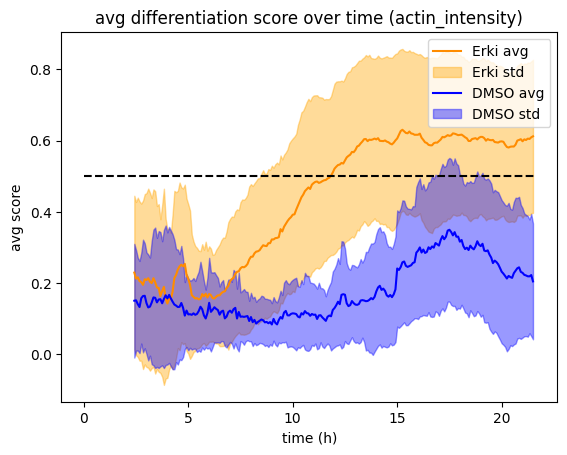

<Figure size 640x480 with 0 Axes>

In [18]:
plot_avg_score(df_score_con.drop("Spot track ID", axis=1), df_score_dif.drop("Spot track ID", axis=1), modality, f'{save_path}plot_scores_')
